# Fake users classification

This notebook presents binary classification for Fake/NotFake users.

In the Feature Engineering part, we will traduce the 3 insights provided in the .pdf.

The Feature Engineering leverages Scikit-learn Transformers for a possible future use of Scikit pipelines.

INSTALL

In [2]:
!pip install lightgbm

IMPORTS

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import dump, load

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, ParameterSampler, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Exploration

In [5]:
df = pd.read_csv('fake_users.csv', index_col=0)

## Basic

In [6]:
df.head()

,UserId,Event,Category,Fake
0,F7A7BF3761,click_carrousel,Phone,0
1,BA8F7A71E6,send_sms,Motor,0
2,21C64F22FC,send_email,Jobs,0
3,F9E0306603,send_sms,Jobs,0
4,1B2143BACC,click_ad,Phone,0


In [7]:
print(df.shape)

(100473, 4)


## Missing values

In [8]:
df[df.isnull().any(axis=1)]

,UserId,Event,Category,Fake


## categoricals

In [9]:
df.nunique()

UserId      5300
Event          5
Category       6
Fake           2
dtype: int64

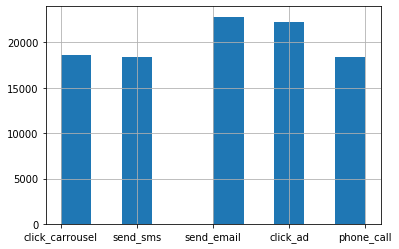

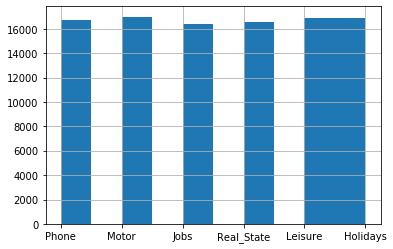

In [10]:
for cat_col in ["Event", "Category"]:
    plt.figure()
    df[cat_col].hist()

## target

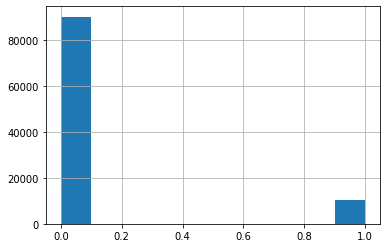

In [11]:
plt.figure()
df['Fake'].hist()

## OneHotEncoding

Here, we will take into account `Event` and `Category` as possible categorical variables.

As we have not a relation order inside the two categorical features, we could use _One Hot Encoding_ strategy (without any risk to explode columns number as we have few modalities for each, `5` and `6` respectively)

In [12]:
class OneHotEncoding(BaseEstimator, TransformerMixin):
    '''
    One-hot-encode the columns of a dataset

    Attributes:
        ohe (`sklearn.preprocessing.OneHotEncoder`): the wrapped sklearn encoder
    '''
    def __init__(self):
        self.ohe = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        '''
        fit the one-hot-encoder
        
        Args:
            X (`pandas.DataFrame`) features dataset
            y (list): target

        Returns:
            None
        '''
        self.ohe.fit(X, y)
        return self

    def transform(self, X, y=None):
        '''
        one hot encode a dataset
        
        Args:
            X (`pandas.DataFrame`) features dataset
            y (list): target

        Returns:
            `pd.DataFrame`: the transformed dataset
        '''
        X_new = pd.DataFrame(self.ohe.transform(X).todense(), columns=self.ohe.get_feature_names())
        return X_new

onehotencoder = OneHotEncoding()
onehotencoder.fit(df[['Event', 'Category']])
df_ohe = onehotencoder.transform(df[['Event', 'Category']])
df_ohe.head()

,x0_click_ad,x0_click_carrousel,x0_phone_call,x0_send_email,x0_send_sms,x1_Holidays,x1_Jobs,x1_Leisure,x1_Motor,x1_Phone,x1_Real_State
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Data Engineering

## INSIGHT 1 : "A bot tends to produce more clicks in an a window period of time than a real user"

Here, we will count the number of clicks types for each user.

For that, we can define a Transformer that takes the one-hot-encoded `Event` to sum-aggregate by `UserId`

In [13]:
class ColumnAggregatorByCategoryAndEvent(BaseEstimator, TransformerMixin):
    def __init__(self, on, aggregators):
        '''
        Aggregate all colums of a dataframe on a predefined column "on" \
        and using various predefined classical "aggregators" (count, sum, nunique, ...)

        Args:
            on (str): column to aggregate on
            aggregators (list): list gathering pandas aggregator methods to apply

        Attributes:
            on (str): column to aggregate on 
            aggregators (list): list gathering pandas aggregator methods to apply
        '''
        self.on = on
        self.aggregators = aggregators
    
    def fit(self, X, y=None):
        '''
        fit the transformer
        
        Args:
            X (`pandas.DataFrame`) features dataset
            y (list): target

        Returns:
            None
        '''
        return self
    
    def transform(self, X, y=None):
        '''
        transform a dataset
        
        Args:
            X (`pandas.DataFrame`) features dataset
            y (list): target

        Returns:
            `pd.DataFrame`: the transformed dataset
        '''
        X_new = X.copy()
        for col in X_new.columns:
            if col in self.on:
                continue
            for agg in self.aggregators:
                X_new[f"{col}_{agg}"] = X_new[[col] + self.on].groupby(self.on).\
                transform(agg)
        for col in X.columns:
            X_new.drop(col, axis=1, inplace=True)
        return X_new.loc[X.index]



cabcav = ColumnAggregatorByCategoryAndEvent(on=['UserId'], aggregators = ['sum'])
clicks_cols = [col for col in df_ohe if "click" in col]
X1 = cabcav.fit_transform(pd.concat([df[['UserId']], df_ohe[clicks_cols]], axis=1))
X1.head()

,x0_click_ad_sum,x0_click_carrousel_sum
0,6.0,4.0
1,3.0,2.0
2,5.0,3.0
3,2.0,4.0
4,2.0,3.0


In [14]:
# verif that during the 5 minutes, first row (UserID=='F7A7BF3761') has :
# * clicked 6 ads
# * clicked 4 carrousel
df.loc[df['UserId'] == 'F7A7BF3761', "Event"].value_counts()

click_ad           6
click_carrousel    4
send_email         3
phone_call         2
send_sms           1
Name: Event, dtype: int64

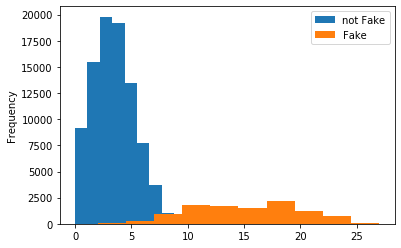

In [15]:
plt.figure()
X1.loc[df['Fake']==0, "x0_click_ad_sum"].rename('not Fake').plot.hist(legend='not Fake')
X1.loc[df['Fake']==1, "x0_click_ad_sum"].rename('Fake').plot.hist(legend='Fake')

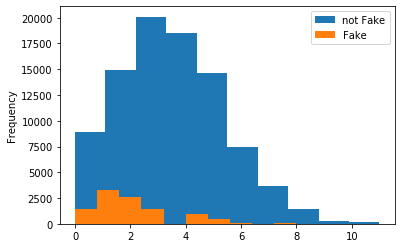

In [16]:
plt.figure()
X1.loc[df['Fake']==0, "x0_click_carrousel_sum"].rename('not Fake').plot.hist(legend='not Fake')
X1.loc[df['Fake']==1, "x0_click_carrousel_sum"].rename('Fake').plot.hist(legend='Fake')

Only the `click_ad` add seems to be discriminative, we can remove it

In [17]:
X1.drop(['x0_click_carrousel_sum'], inplace=True, axis=1)

In [18]:
X1.head()

,x0_click_ad_sum
0,6.0
1,3.0
2,5.0
3,2.0
4,2.0


## INSIGHT 2: "While real users interact with just a small subset of categories in a window time, bots behaviour are not centered into specific categories and interact with a vast majority of them."

Here we will count the uniqueness of `Category` for each user. 

We can re-use the Transformer `ColumnAggregatorByCategoryAndEvent` but using `nunique` as aggregator

In [19]:
nubcav = ColumnAggregatorByCategoryAndEvent(on=['UserId'], aggregators = ['nunique'])
X2 = nubcav.fit_transform(df[['UserId', 'Category']])
X2.head()

,Category_nunique
0,4
1,2
2,4
3,4
4,2


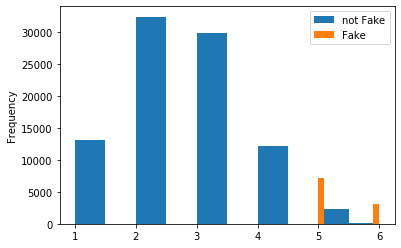

In [20]:
plt.figure()
X2.loc[df['Fake']==0, "Category_nunique"].rename('not Fake').plot.hist(legend='not Fake')
X2.loc[df['Fake']==1, "Category_nunique"].rename('Fake').plot.hist(legend='Fake')

As expected, the variable is discriminative : high value for Fake users

## INSIGHT 3: "The distribution of clicks for a given bot tends to be skewed towards clicks like click_ad and send_email, because the former can bias our algorithms and the latter aims to annoy our sellers."

Here we will count the proportions of `click_ad` and `send_email` for each user. 

Here again, we can use our `ColumnAggregatorByCategoryAndEvent`, using a custom aggregators to compute the two proportions

In [21]:
def agg_percentage_click_ad(x):
    return x[x == "click_ad"].count()/x.count()

def agg_percentage_send_email(x):
    return x[x == "send_email"].count()/x.count()

In [22]:
pcabcav = ColumnAggregatorByCategoryAndEvent(on=['UserId'], aggregators = [agg_percentage_click_ad, agg_percentage_send_email])
X3 = pcabcav.fit_transform(df[['UserId', 'Event']])
X3.head()

,Event_<function agg_percentage_click_ad at 0x7f9b89336440>,Event_<function agg_percentage_send_email at 0x7f9b89336560>
0,0.375000,0.1875
1,0.200000,0.2000
2,0.250000,0.3000
3,0.125000,0.2500
4,0.133333,0.2000


In [23]:
# Here again we can perform verification for the first UserId
df.loc[df['UserId'] == 'F7A7BF3761', "Event"].value_counts(normalize=True)

click_ad           0.3750
click_carrousel    0.2500
send_email         0.1875
phone_call         0.1250
send_sms           0.0625
Name: Event, dtype: float64

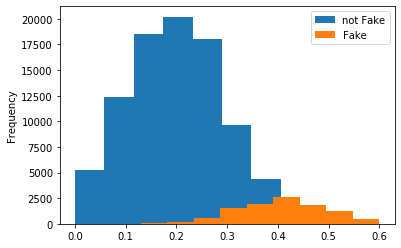

In [24]:
plt.figure()
col_click_ad = [col for col in X3.columns if 'click_ad' in col][0]
X3.loc[df['Fake']==0, col_click_ad].rename('not Fake').plot.hist(legend='not Fake')
X3.loc[df['Fake']==1, col_click_ad].rename('Fake').plot.hist(legend='Fake')

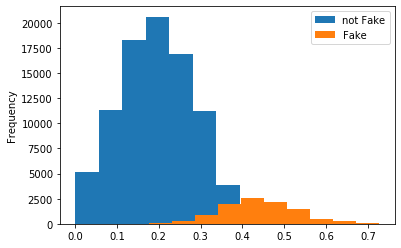

In [25]:
plt.figure()
col_send_email = [col for col in X3.columns if 'send_email' in col][0]
X3.loc[df['Fake']==0, col_send_email].rename('not Fake').plot.hist(legend='not Fake')
X3.loc[df['Fake']==1, col_send_email].rename('Fake').plot.hist(legend='Fake')

As expected, there is a high proportion of `click_ad` and `send_email` among fake users

# Pipeline

Now we can concatenate the 3 dataframes from the 3 insights

In [26]:
X = pd.concat([X1, X2, X3], axis=1)

In [27]:
X.head()

,x0_click_ad_sum,Category_nunique,Event_<function agg_percentage_click_ad at 0x7f9b89336440>,Event_<function agg_percentage_send_email at 0x7f9b89336560>
0,6.0,4,0.375000,0.1875
1,3.0,2,0.200000,0.2000
2,5.0,4,0.250000,0.3000
3,2.0,4,0.125000,0.2500
4,2.0,2,0.133333,0.2000


In [28]:
y = df['Fake']

# Model Training

Here we will grid search the best params of a light gbm classifier with early stopping.

As the number of features is weak, we will carefully choose the parameters to avoid overfitting.

In [29]:
lgbm = LGBMClassifier(n_estimators=10, n_jobs=4)

## train/test split

In [30]:
Xtrainval, Xtest, ytrainval, ytest = train_test_split(X, y, test_size=0.2)

## Validation Strategy

In [31]:
seed=1984
vs = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

## Params grid

In [32]:
param_grid = {
 'num_leaves': [1000],
#  'learning_rate': [0.1],
#  'n_estimators': [10],
#  'min_child_samples': [10, 20, 30],
 'metric': ['binary_logloss'],
 'subsample': [0.05, 0.1],
 'colsample_bytree': [0.25, 0.5],
 'reg_alpha': [1000.0],
 'reg_lambda': [1000.0],
 'class_weight': ['balanced'],
 'max_depth': [1, 2]}

## Grid Search


In [33]:
os.makedirs('./models/', exist_ok=True)

In [34]:
n_iters = 10

In [35]:
param_samp = ParameterSampler(param_grid, n_iters, random_state=seed)

In [36]:
def save_model(model, stats_dict, hash_key):
    if os.path.exists('./models/perf_res_dict.joblib'):
        d = load('./models/perf_res_dict.joblib')
    else:
        d = {}
    dump(model,'./models/' + str(hash_key)+'.joblib')
    d[hash_key] = stats_dict.copy()
    dump(d, './models/perf_res_dict.joblib')

In [37]:
for par in param_samp:
    lgbm.set_params(**par)
    print (par)
    
    perf_dict = {}
    best_iter = {}
    
    for i, (train, val) in enumerate(vs.split(Xtrainval, ytrainval)):
        Xtrain, ytrain = Xtrainval.iloc[train,:], ytrainval.iloc[train]
        Xval, yval = Xtrainval.iloc[val,:], ytrainval.iloc[val]
        var_lgbm = list(Xtrainval.columns)
        lgbm.fit(
            Xtrain,
            ytrain,
            eval_set=[(Xval, yval)],
            eval_names=['validation'],
            eval_metric= 'auc', 
            early_stopping_rounds = 10,
            verbose=100,
        )
        perf_dict['metric' + str(i)] = lgbm.best_score_['validation']['auc']
        best_iter['iter' + str(i)] = lgbm.best_iteration_
    
    hash_key = str(hash((frozenset(par.items()),frozenset(var_lgbm)))) +  '_lgbm'
    perf_dict['mean'] = np.mean(list(perf_dict.values()))
    stats = {}
    stats.update(par)
    stats.update(perf_dict)
    stats.update(best_iter)
    save_model(lgbm, stats, hash_key)
  

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


{'subsample': 0.05, 'reg_lambda': 1000.0, 'reg_alpha': 1000.0, 'num_leaves': 1000, 'metric': 'binary_logloss', 'max_depth': 1, 'colsample_bytree': 0.25, 'class_weight': 'balanced'}
{'subsample': 0.1, 'reg_lambda': 1000.0, 'reg_alpha': 1000.0, 'num_leaves': 1000, 'metric': 'binary_logloss', 'max_depth': 1, 'colsample_bytree': 0.25, 'class_weight': 'balanced'}


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


{'subsample': 0.05, 'reg_lambda': 1000.0, 'reg_alpha': 1000.0, 'num_leaves': 1000, 'metric': 'binary_logloss', 'max_depth': 2, 'colsample_bytree': 0.25, 'class_weight': 'balanced'}


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


{'subsample': 0.1, 'reg_lambda': 1000.0, 'reg_alpha': 1000.0, 'num_leaves': 1000, 'metric': 'binary_logloss', 'max_depth': 2, 'colsample_bytree': 0.25, 'class_weight': 'balanced'}


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


{'subsample': 0.05, 'reg_lambda': 1000.0, 'reg_alpha': 1000.0, 'num_leaves': 1000, 'metric': 'binary_logloss', 'max_depth': 1, 'colsample_bytree': 0.5, 'class_weight': 'balanced'}


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


{'subsample': 0.1, 'reg_lambda': 1000.0, 'reg_alpha': 1000.0, 'num_leaves': 1000, 'metric': 'binary_logloss', 'max_depth': 1, 'colsample_bytree': 0.5, 'class_weight': 'balanced'}


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


{'subsample': 0.05, 'reg_lambda': 1000.0, 'reg_alpha': 1000.0, 'num_leaves': 1000, 'metric': 'binary_logloss', 'max_depth': 2, 'colsample_bytree': 0.5, 'class_weight': 'balanced'}


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


{'subsample': 0.1, 'reg_lambda': 1000.0, 'reg_alpha': 1000.0, 'num_leaves': 1000, 'metric': 'binary_logloss', 'max_depth': 2, 'colsample_bytree': 0.5, 'class_weight': 'balanced'}


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [38]:
perfs = load('./models/perf_res_dict.joblib')
perfs = pd.DataFrame(perfs).T.sort_values('mean', ascending=False)
perfs

,subsample,reg_lambda,reg_alpha,num_leaves,metric,max_depth,colsample_bytree,class_weight,metric0,metric1,metric2,metric3,metric4,mean,iter0,iter1,iter2,iter3,iter4
-4612949262016558317_lgbm,0.05,1000,1000,1000,binary_logloss,1,0.25,balanced,0.999936,0.999913,0.9999,0.999919,0.999899,0.999913,8,4,4,8,8
-7308004940170867517_lgbm,0.1,1000,1000,1000,binary_logloss,1,0.25,balanced,0.999936,0.999913,0.9999,0.999919,0.999899,0.999913,8,4,4,8,8
-6668343280794228700_lgbm,0.05,1000,1000,1000,binary_logloss,2,0.25,balanced,0.999946,0.999739,0.999925,0.999935,0.999847,0.999878,8,8,8,8,6
-2228429013292290380_lgbm,0.1,1000,1000,1000,binary_logloss,2,0.25,balanced,0.999946,0.999739,0.999925,0.999935,0.999847,0.999878,8,8,8,8,6
7003684120943765540_lgbm,0.05,1000,1000,1000,binary_logloss,2,0.5,balanced,0.9994,0.999167,0.999424,0.999556,0.999412,0.999392,8,8,4,4,8
-1858909010899898700_lgbm,0.1,1000,1000,1000,binary_logloss,2,0.5,balanced,0.9994,0.999167,0.999424,0.999556,0.999412,0.999392,8,8,4,4,8
-572413543708996845_lgbm,0.05,1000,1000,1000,binary_logloss,1,0.5,balanced,0.99854,0.998242,0.998476,0.998499,0.998485,0.998448,6,6,5,5,5
8428037612057447619_lgbm,0.1,1000,1000,1000,binary_logloss,1,0.5,balanced,0.99854,0.998242,0.998476,0.998499,0.998485,0.998448,6,6,5,5,5


Load best model for further predictions

In [39]:
hash_best_model = perfs.index[0]
lgbm_best = load('./models/' + hash_best_model + '.joblib')

# Holdout

In [40]:
df_ho = pd.read_csv('fake_users_test.csv')

## INSIGHT 1

In [41]:
df_ohe_ho = onehotencoder.transform(df_ho[['Event', 'Category']])
X1_ho = cabcav.fit_transform(pd.concat([df_ho[['UserId']], df_ohe_ho[clicks_cols]], axis=1))

In [42]:
X1_ho.drop(['x0_click_carrousel_sum'], inplace=True, axis=1)

## INSIGHT 2

In [43]:
X2_ho = nubcav.fit_transform(df_ho[['UserId', 'Category']])

## INSIGHT 3

In [44]:
X3_ho = pcabcav.fit_transform(df_ho[['UserId', 'Event']])

## Predictions

We load the test to compute predictions and accuracy

In [45]:
X_ho = pd.concat([X1_ho, X2_ho, X3_ho], axis=1)

In [46]:
df_ho['pred'] = lgbm_best.predict(X_ho)

In [47]:
accuracy_score(df_ho['Fake'], df_ho['pred'])

1.0